<h1><center>Bandpass Filter Parameter Estimation using PyMC</center></h1>
<h2><center>Solving the Model System in parts</center></h2>
The approach to solving the bandpass parameter estimation problem is to break it down into two parts, essentially simulating its response as a *lowpass filter* followed by a *highpass filter*. Since the last update, I've also simplified the model further keeping only the essential differential equations. Intracellular concentrations of metabolites not directly affected by the bandpass filter like $ [LacI]$ and $[AmpR]$ are considered to be constant. I've also not taken into consideration *Hitchhicker protein's* mechanism with the assumption that it will only modulate some of the constants optimized and not have an effect on the structure of the ODEs.

The model equations are as follows:

$\frac{d[BLA]}{dt}= \frac{\beta_{BLA}}{1+\Big(\frac{[LacI]_{T}\Big/K_{LacI}}{ 1+\big( 
[IPTG]\big/K_{IPTG}\big) ^{\eta_{IPTG}} }\Big) ^{\eta_{LacI}}}- \gamma _{BLA}[BLA]$ 

$\frac{d[Amp]}{dt}= k_{t,Amp}([Amp]_{ext}-[Amp] ) -\frac{k_{cat,BLA}[BLA][Amp]}{K_{m,BLA}+[Amp] }$ 

[//]:($\frac{d[aMPp]}{dt}= k_{Amp}\lbrack Amp\rbrack - \gamma _{aMPp}\lbrack 
aMPp\rbrack $)

$\frac{d[TetC]}{dt}= \frac{\beta _{TetC}}
{1+ \Big( \frac{[AmpR]\Big/K_{AmpR}}{1+\big([Amp]\big/K_{Amp}\big) ^{\eta {Amp}} }\big) ^{\eta _{AmpR}}}- \gamma _{TetC}[TetC]$

$\frac{d[Tet]}{dt}= k_{t,Tet}([Tet]_{ext}-[Tet]) - k_{TetC}[TetC][Tet]$

In [1]:
import pymc as pm
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
exp=np.genfromtxt("expdata.txt", delimiter='\t')
amp0=np.genfromtxt("amp0.txt", delimiter='\t')
iptg=exp[:,0]
tet0=exp[:,1]
MIC_exp=exp[:,2]
IND_exp=exp[:,3]
amp0=np.sort(amp0)

In [3]:
#defining prior distributions of our unknown variables 
constants_prob = pm.Uniform('constants_prob', 0.01, 1.0,size=8)


@pm.deterministic
def lowpass(constants_prob=constants_prob,iptg=iptg, amp0=amp0):
    bg_bla=constants_prob[0]*5000     #20/0.1 #uM/min combo of beta and gamma
    laci=constants_prob[1]*50         #0.01 #uM combo of laci/kd_laci
    #kd_laci=constants_prob[2]*5e-3    #7.8e-4 #uM
    n_laci=constants_prob[2]*5        #2.5
    kd_iptg=constants_prob[3]*50      #25 #uM
    n_iptg=constants_prob[4]*5        #2
    #kcat=constants_prob[6]*5e6        #2.82e5 #1/m
    km=constants_prob[5]*500          #100 #uM
    ktr=constants_prob[6]*1e-2         #1e3 Combo of ktr and kcat
    MIC_int=constants_prob[7]*5       #amp[0,5]
    
    
    bla=np.zeros(len(iptg))
    for i in range(len(iptg)):
        D_iptg=1+(iptg[i]/kd_iptg)**n_iptg
        D_laci=1+(laci/(D_iptg))**n_laci
        bla[i]=bg_bla/D_laci

    #amp0=[2**i for i in range(12) ]
    amp=np.zeros((len(bla),len(amp0)))
    for i in range(len(bla)):
        for j in range(len(amp0)):
            coeff=[-ktr,(ktr*amp0[j]-ktr*km-bla[i]),ktr*amp0[j]*km]
            sol=np.roots(coeff)
            if sol[0]>=0 and sol[0]<amp0[j]:
                amp[i,j]=sol[0]
            else:
                amp[i,j]=sol[1]

    #amp=amp*349.41/1000 #convert to ug/ml

    MIC_mod=np.zeros(len(iptg))
    for i in range(len(iptg)):
        for j in range(len(amp0)):
            if amp[i,j]>=MIC_int:
                break
            MIC_mod[i]=amp0[j]
    return MIC_mod

In [4]:
observed_MIC = pm.Normal('observed_MIC', mu=lowpass,tau=1000,value=MIC_exp, observed=True)

In [5]:
model = pm.Model([constants_prob,lowpass,observed_MIC])
 
# fit the model with mcmc
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(20000, burn=5000, thin=50)

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:32: ComplexWarning: Casting complex values to real discards the imaginary part


 [-----------------100%-----------------] 20000 of 20000 complete in 126.4 sec

In [6]:
#MCMC samples turned to arrays
constants_samples=mcmc.trace('constants_prob')[:]
lowpass_samples=mcmc.trace('lowpass')[:]

0.053007720225791852

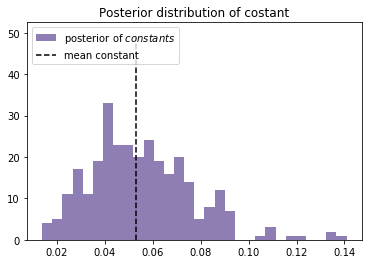

In [8]:
#Histogram of variable 1:kcat
i=0
plt.hist(constants_samples[:,i], histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $constants$", color="#7A68A6");
plt.vlines(np.median(constants_samples[:,i]), 0, 50, linestyle="--", label="mean constant")
plt.legend(loc="upper left")
plt.title("Posterior distribution of costant")
np.median(constants_samples[:,i])

In [ ]:
import pandas as pd
medians=np.zeros(8)[:,None]
for i in range(8):
    medians[i]=np.median(constants_samples[:,i]) 

pd.DataFrame(medians.T,columns=['$ bg $','$[LacI]$','$\eta_{LacI}$',iptg[3],iptg[4],iptg[5],iptg[6],iptg[7]])

In [13]:
constants_samples[20]

array([ 0.04915429,  0.62570899,  0.3169802 ,  0.64259643,  0.34806679,
        0.26766727,  0.18546096,  0.14453938])

In [14]:
print('model:',lowpass_samples[20])
print('Exp:', MIC_exp)

model: [  56.25  225.    225.    450.    450.    450.    225.    225.    225.
  225.    225.    225.  ]
Exp: [  56.25  225.    225.    450.    450.    450.    225.    450.    225.
  225.    225.    225.  ]


In [ ]:
from IPython.core.display import HTML


def css_styling():
    styles = open("styles/custom.css", "r").read()
    return HTML(styles)
css_styling()